In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('pokemon.csv')

In [3]:
df.head()

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    809 non-null    object
 1   Type1   809 non-null    object
dtypes: object(2)
memory usage: 12.8+ KB


In [5]:
df.describe()

,Name,Type1
count,809,809
unique,809,18
top,melmetal,Water
freq,1,114


In [6]:
df.isnull().sum()
#checking if any empty values are present

,0
Name,0
Type1,0


In [7]:
df['Type1'].unique()
#displaying what are all the values for this column

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [8]:
df['Type1'].nunique()

18

In [9]:
%matplotlib inline

<Axes: xlabel='Type1', ylabel='count'>

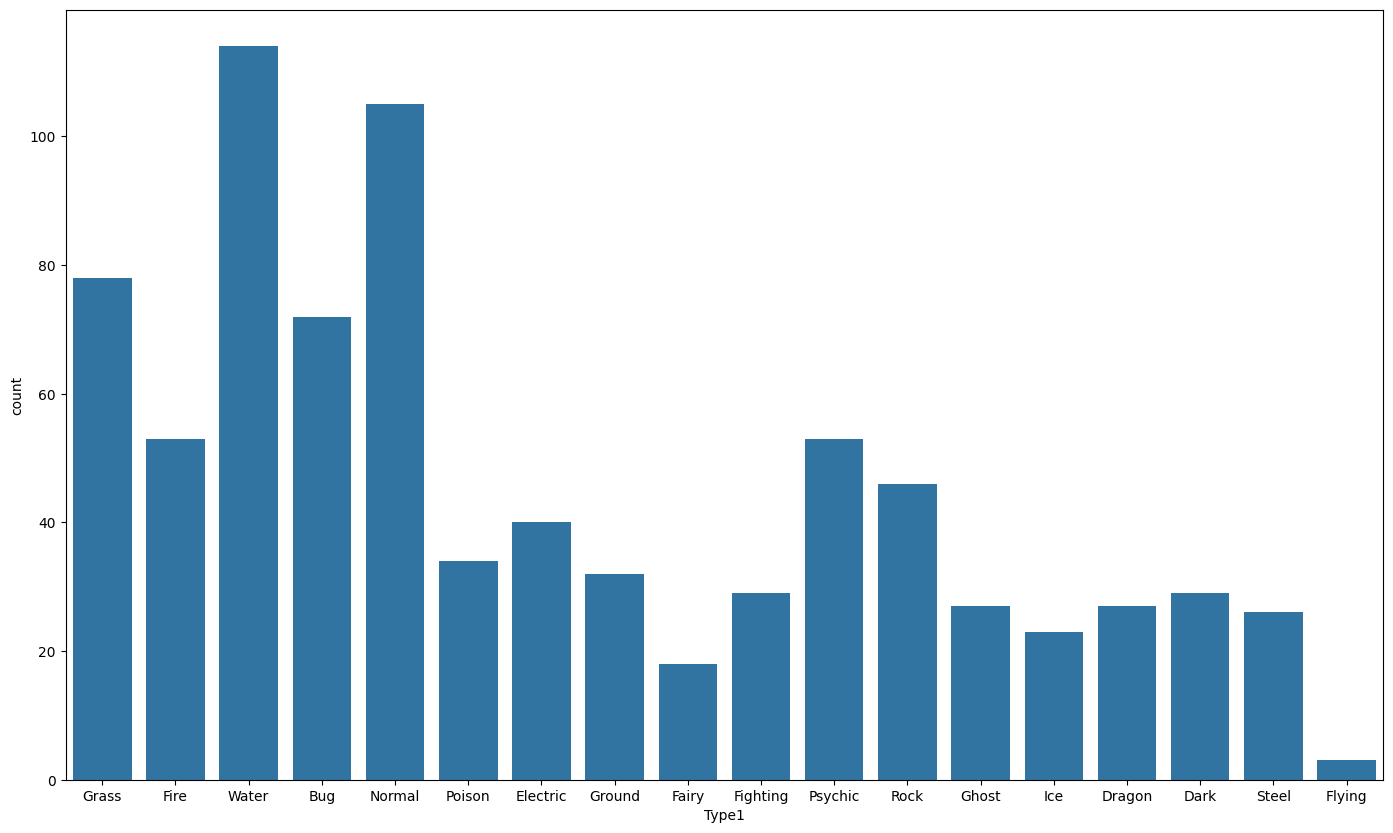

In [10]:
plt.figure(figsize=(17,10))
sns.countplot(x='Type1',data=df)

Found the count of each type and we can clearly see 'water' and 'normal' are the highest , 'flying' has the lowest count

In [11]:
df['Name'].nunique()

809

In [ ]:
#we have 809 unique pokemons in oyr dataset

In [12]:
import zipfile
import os

# Path where your zip was uploaded
zip_path = "/content/images.zip"

# Extract to /content/images
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/images")

In [19]:
image_dir = "/content/images/images"

print(os.listdir(image_dir)[:10])

['geodude.png', 'gorebyss.png', 'gabite.png', 'zapdos.png', 'vivillon.png', 'mesprit.png', 'inkay.png', 'cinccino.png', 'diancie.png', 'clefairy.png']


In [20]:
# image folder
image_dir = "/content/images/images"

# Build paths
X = [os.path.join(image_dir, name + ".png") for name in df["Name"]]
y = df["Type1"]

In [24]:
X[:3]

['/content/images/images/bulbasaur.png',
 '/content/images/images/ivysaur.png',
 '/content/images/images/venusaur.png']

In [23]:
image_dir = "/content/images/images"


X_train = [os.path.join(image_dir, os.path.basename(f)) for f in X_train]
X_val   = [os.path.join(image_dir, os.path.basename(f)) for f in X_val]
X_test  = [os.path.join(image_dir, os.path.basename(f)) for f in X_test]

# Quick check
for path in X_train[:5]:
    print(path, os.path.exists(path))


/content/images/images/volcarona.png True
/content/images/images/magmar.png True
/content/images/images/elgyem.png True
/content/images/images/dodrio.png True
/content/images/images/pangoro.png True


In [ ]:
#Converting y variables from Series to list form. Easier to process and index when building the pipeline.

In [25]:
y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)

y_train[:3]

['Bug', 'Fire', 'Psychic']

In [ ]:
#Displaying some images inorder to verify the state of our X and y so far.

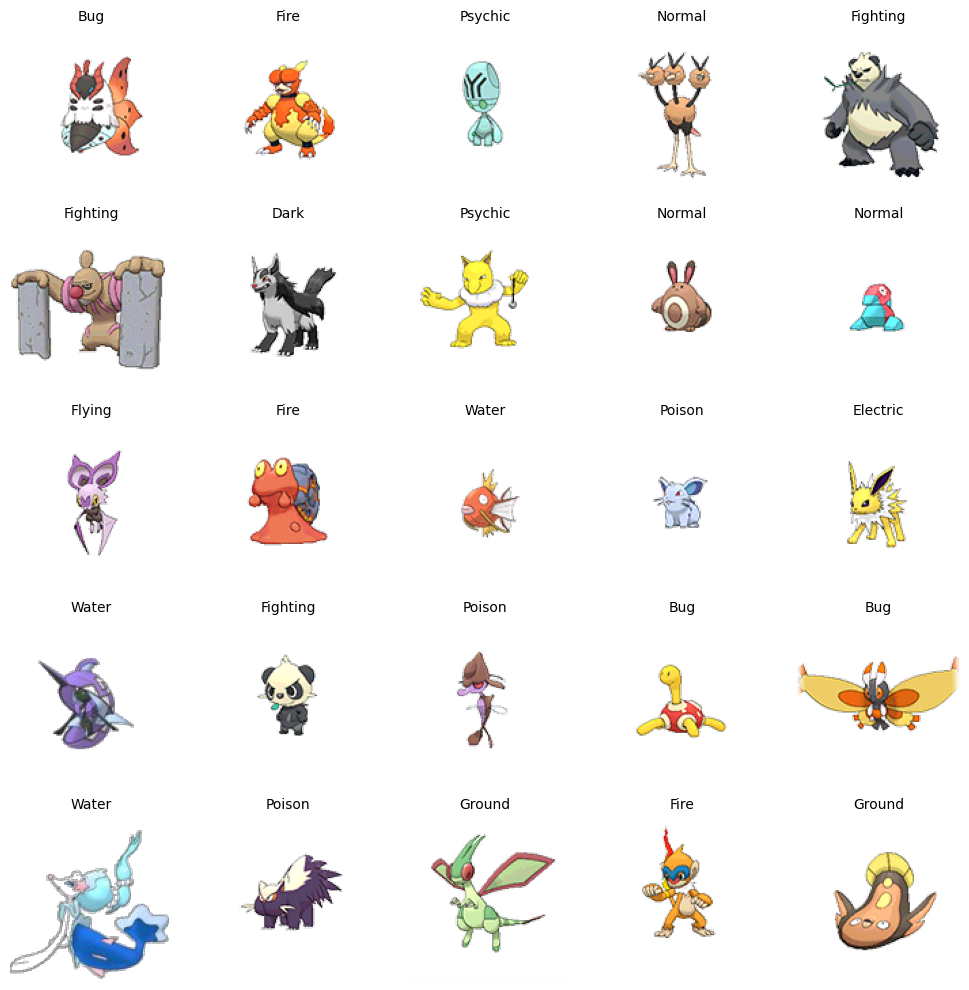

In [26]:
from PIL import Image
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.reshape(-1)):
    img_path = X_train[i]
    label = y_train[i]

    ax.set_title(label, size=10)
    ax.imshow(Image.open(img_path))
    ax.axis("off")
plt.tight_layout()

In [27]:
#now we want to multiencode the Type1

from sklearn.preprocessing import MultiLabelBinarizer

# Wrap each label into a list to prevent mlb from assigning label to each character
y_train_fixed = [[lbl] for lbl in y_train]
y_val_fixed   = [[lbl] for lbl in y_val]
y_test_fixed  = [[lbl] for lbl in y_test]

mlb = MultiLabelBinarizer()
mlb.fit(y_train_fixed)

print("Labels: ")
for i, label in enumerate(mlb.classes_):
    print(f"{i}. {label}")

Labels: 
0. Bug
1. Dark
2. Dragon
3. Electric
4. Fairy
5. Fighting
6. Fire
7. Flying
8. Ghost
9. Grass
10. Ground
11. Ice
12. Normal
13. Poison
14. Psychic
15. Rock
16. Steel
17. Water


In [28]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train_fixed)
y_val_bin = mlb.transform(y_val_fixed)
y_test_bin = mlb.transform(y_test_fixed)

# printing example of posters and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])

/content/images/images/volcarona.png [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
/content/images/images/magmar.png [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
/content/images/images/elgyem.png [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


In [29]:
y_train_bin.shape, y_val_bin.shape, y_test_bin.shape

((691, 18), (77, 18), (41, 18))

In [30]:
len(X_train), len(X_val), len(X_test)

(691, 77, 41)

In [31]:
#preprocessing the images , resize to fixed size and normalize pixel values
import tensorflow as tf

IMG_SIZE = (128, 128)

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

In [32]:
#turn data into tf.data pipeline

BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_bin))
train_ds = train_ds.map(load_and_preprocess).shuffle(500).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_bin))
val_ds = val_ds.map(load_and_preprocess).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_bin))
test_ds = test_ds.map(load_and_preprocess).batch(BATCH_SIZE)

Building a CNN model

In [33]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(mlb.classes_), activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compiling the model

In [34]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

Train

In [35]:
history = model.fit(train_ds,validation_data=val_ds,epochs=20)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - accuracy: 0.1066 - loss: 2.8793 - val_accuracy: 0.1818 - val_loss: 2.6884
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1244 - loss: 2.7454 - val_accuracy: 0.2468 - val_loss: 2.4494
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1848 - loss: 2.6273 - val_accuracy: 0.2468 - val_loss: 2.4557
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2554 - loss: 2.4608 - val_accuracy: 0.2468 - val_loss: 2.4959
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2793 - loss: 2.3590 - val_accuracy: 0.2338 - val_loss: 2.5430
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3114 - loss: 2.1438 - val_accuracy: 0.2597 - val_loss: 2.5911
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4179 - loss: 1.8275 - val_accuracy: 0.2078 - val_loss: 2.5821
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5380 - loss: 1.5392 - val_accuracy: 0.2208 -

Visualize Training

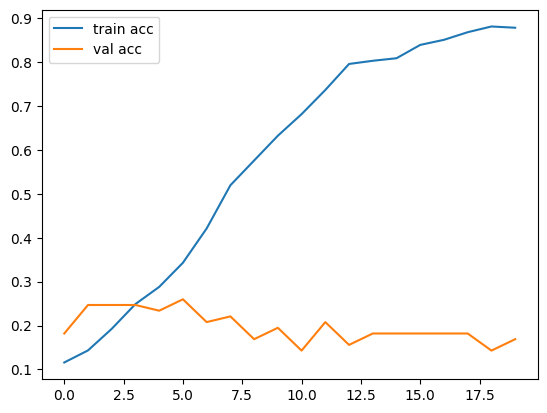

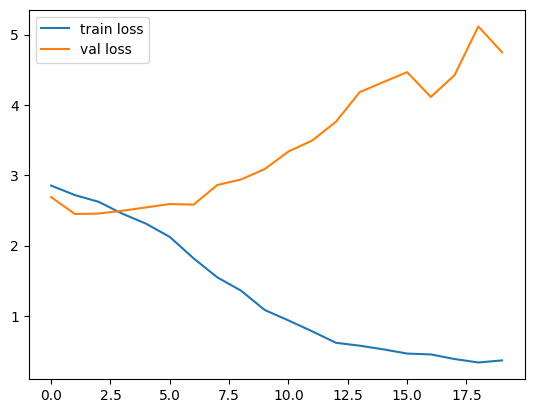

In [36]:
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

1. Accuracy Graph (First Image)

The model is overfitting: it learns training data well but fails to generalize to validation data.

Validation accuracy being flat suggests the model isn’t capturing useful patterns for unseen data.


2. Loss Graph (Second Image)

Confirms overfitting as training loss goes down, validation loss rises, showing the model memorizes training data instead of generalizing.

Evaluate on test set

In [37]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step - accuracy: 0.2297 - loss: 4.5211
Test Accuracy: 0.2195121943950653


Model is basically guessing randomly (close to 1/number_of_classes).

It memorized training data (high training accuracy ~0.9) but failed to generalize.

Validation accuracy stayed flat and test accuracy confirms poor generalization.

In [38]:
#checking predictions

pred = model.predict(test_ds.take(1))
print("Predicted:", mlb.classes_[pred[0].argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
Predicted: Grass


Pipeline used:

**Data Loading & Exploration:** Loaded Pokémon data from 'pokemon.csv', checked for nulls, inspected unique 'Type1' values, and visualized their distribution using Seaborn.

**Image Extraction**: Unzipped a folder of Pokémon images and mapped each Pokémon name to its corresponding .png image file.

**Train/Val/Test Split**: Split the dataset (names and types) into training, validation, and test sets using train_test_split.

**Image Path Preparation**: Created lists of file paths corresponding to images for each split (train/val/test), checked file existence, and matched labels.

**Image Visualization**: Used Pillow and Matplotlib to visualize a few sample images alongside their associated 'Type1' labels.

**Type Encoding**: Used MultiLabelBinarizer to encode the 'Type1' labels as one-hot vectors for model training.

**Image Preprocessing**: Defined a TensorFlow image preprocessing pipeline (resize to 128x128, normalize) and created batched tf.data.Dataset objects for train, val, and test sets.

**Model Construction**: Built a sequential CNN with three convolution/pooling layers, a dense and dropout layer and a final softmax classification layer with categorical cross-entropy loss.

**Training & Evaluation**: Trained the model for 20 epochs, plotted accuracy/loss curves, and evaluated on the test set, resulting in ~22% test accuracy.

**Prediction Example**: Displayed a sample predicted label from the test set.

In [39]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [40]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [41]:
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    img = data_augmentation(img)
    return img, label

In [42]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_bin))
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_bin))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_bin))
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [43]:
# Transfer learning: feature extractor
base_model = MobileNetV2(input_shape=(128,128,3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [44]:
# Build final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(mlb.classes_), activation="softmax")
])

In [45]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

In [47]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.0908 - loss: 3.4713 - val_accuracy: 0.2727 - val_loss: 2.5855 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.1580 - loss: 2.6769 - val_accuracy: 0.2338 - val_loss: 2.6248 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.1640 - loss: 2.6237 - val_accuracy: 0.2468 - val_loss: 2.5831 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.1835 - loss: 2.5538 - val_accuracy: 0.2727 - val_loss: 2.5059 - learning_rate: 0.0010
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.1954 - loss: 2.4566 - val_accuracy: 0.2597 - val_loss: 2.4825 - learning_rate: 0.0010
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.2131 - loss: 2.4534 - val_accuracy: 0.2857 - val_loss: 2.3838 - learning_rate: 0.0010
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.2470 - loss: 2.3119 - val_accu

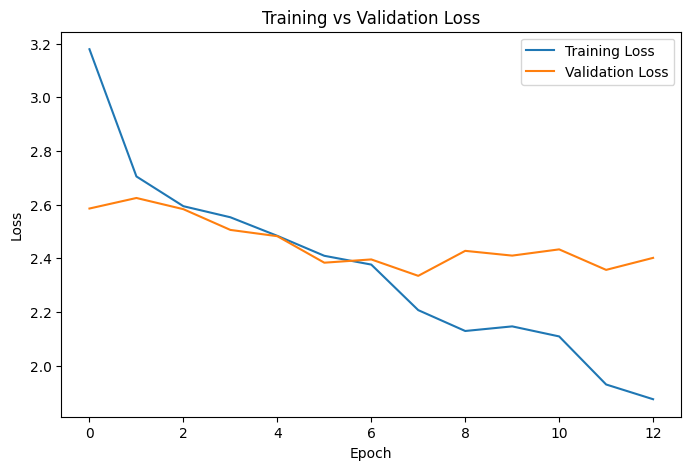

In [48]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

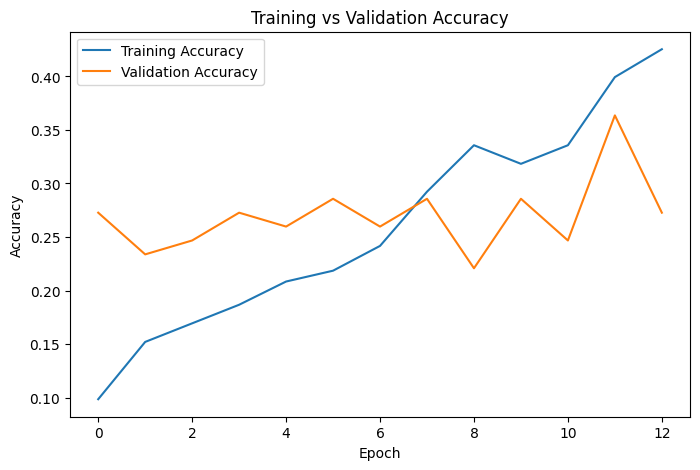

In [49]:
# Training and Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [50]:
# Test Accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.2726 - loss: 2.4349
Test Accuracy: 0.2683


**Model Architecture**: Switched to a transfer learning approach, freezing a pre-trained MobileNetV2 backbone and stacking custom dense layers for classification.

**Regularization & Augmentation**: Integrated data augmentation (random flips, zooms, rotations) and dropout to combat overfitting.

**Training & Evaluation**: Monitored training/validation loss and accuracy for 13 epochs with early stopping. Best test accuracy achieved was 0.27 (27%).

**Performance Visualization**: Plotted training vs. validation loss and accuracy, providing insight into learning dynamics and model generalization. We can clearly see the improvement in test accuracy from 22% to 27%